In [1]:
# 07-30 update tmp=min(y_n-target, target_H)
from numpy.random import RandomState
import numpy as np
np.set_printoptions(precision=2,suppress=True)

import matplotlib.pyplot as plt
import seaborn as sns
import pdb
import scipy.optimize as opt
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC
from math import *

from scipy.optimize import basinhopping,minimize,differential_evolution
from scipy.stats import moment

In [2]:
# basis functions, phi_pos, phi_neg
def transf_pos(x,K=2.0,y0=0.001,ym=1.5,n=2):
    result=ym*((x/K)**n)/(1+(x/K)**n)+ym*y0
    return result

def transf_neg(x,K=2.0,y0=0.001,ym=1.5,n=2):
    result=ym/(1+(x/K)**n)+y0*ym
    return result

In [3]:
def noisy(vector):
    result=[]
    for i in range(0,len(vector)):
        v=vector.copy()
        v[i]=np.logical_not(vector[i]).astype(int)
        #print(i,vector[i],v[i])
        result.append(v)
    return result



In [4]:
zv_5x5=[1,1,1,0,0,\
        0,0,1,0,0,\
        0,0,1,0,0,\
        0,0,1,0,0,\
        0,0,1,1,1]

zv_7x7=[1,1,1,1,0,0,0,\
        0,0,0,1,0,0,0,\
        0,0,0,1,0,0,0,\
        0,0,0,1,0,0,0,\
        0,0,0,1,0,0,0,\
        0,0,0,1,0,0,0,\
        0,0,0,1,1,1,1]

zv_9x9=[1,1,1,1,1,0,0,0,0,\
        0,0,0,0,1,0,0,0,0,\
        0,0,0,0,1,0,0,0,0,\
        0,0,0,0,1,0,0,0,0,\
        0,0,0,0,1,0,0,0,0,\
        0,0,0,0,1,0,0,0,0,\
        0,0,0,0,1,0,0,0,0,\
        0,0,0,0,1,0,0,0,0,\
        0,0,0,0,1,1,1,1,1]    

In [5]:
vv_5x5=[1,0,0,0,1,\
        1,0,0,0,1,\
        1,0,0,0,1,\
        0,1,0,1,0,\
        0,0,1,0,0]

vv_7x7=[1,0,0,0,0,0,1,\
        1,0,0,0,0,0,1,\
        1,0,0,0,0,0,1,\
        1,0,0,0,0,0,1,\
        0,1,0,0,0,1,0,\
        0,0,1,0,1,0,0,\
        0,0,0,1,0,0,0]

vv_9x9=[1,0,0,0,0,0,0,0,1,\
        1,0,0,0,0,0,0,0,1,\
        1,0,0,0,0,0,0,0,1,\
        1,0,0,0,0,0,0,0,1,\
        1,0,0,0,0,0,0,0,1,\
        0,1,0,0,0,0,0,1,0,\
        0,0,1,0,0,0,1,0,0,\
        0,0,0,1,0,1,0,0,0,\
        0,0,0,0,1,0,0,0,0]    

In [6]:
nv_5x5=[0,0,0,0,0,\
        0,1,1,1,0,\
        1,0,0,0,1,\
        1,0,0,0,1,\
        1,0,0,0,1]

nv_7x7=[0,0,0,0,0,0,0,\
        0,0,0,0,0,0,0,\
        0,1,1,1,1,1,0,\
        1,0,0,0,0,0,1,\
        1,0,0,0,0,0,1,\
        1,0,0,0,0,0,1,\
        1,0,0,0,0,0,1]

nv_9x9=[0,0,0,0,0,0,0,0,0,\
        0,0,0,0,0,0,0,0,0,\
        0,0,1,1,1,1,1,0,0,\
        0,1,0,0,0,0,0,1,0,\
        1,0,0,0,0,0,0,0,1,\
        1,0,0,0,0,0,0,0,1,\
        1,0,0,0,0,0,0,0,1,\
        1,0,0,0,0,0,0,0,1,\
        1,0,0,0,0,0,0,0,1]

In [7]:
# 5x5
zpatterns=([zv_5x5]+noisy(zv_5x5))
vpatterns=([vv_5x5]+noisy(vv_5x5))
npatterns=([nv_5x5]+noisy(nv_5x5))

patterns_5x5=zpatterns+vpatterns+npatterns

In [8]:
# 7x7
zpatterns=([zv_7x7]+noisy(zv_7x7))
vpatterns=([vv_7x7]+noisy(vv_7x7))
npatterns=([nv_7x7]+noisy(nv_7x7))

patterns_7x7=zpatterns+vpatterns+npatterns

In [9]:
# 9x9
zpatterns=([zv_9x9]+noisy(zv_9x9))
vpatterns=([vv_9x9]+noisy(vv_9x9))
npatterns=([nv_9x9]+noisy(nv_9x9))

patterns_9x9=zpatterns+vpatterns+npatterns

In [40]:
# updated 08-25

size=81
patterns=patterns_9x9

target_L=0.0
target_H=1.2
lenth=int(len(patterns)/3)

target_0=np.array([target_H]*lenth+[target_L]*lenth+[target_L]*lenth)
target_1=np.array([target_L]*lenth+[target_H]*lenth+[target_L]*lenth)
target_2=np.array([target_L]*lenth+[target_L]*lenth+[target_H]*lenth)

target=target_0
#----
AHL_unit_level=30 # 30x diuute
transf_p=np.zeros(2)
transf_n=np.zeros(2)

transf_p[0]=transf_pos(x=0,K=50,y0=0.1,ym=1.0,n=0.45)
transf_p[1]=transf_pos(x=AHL_unit_level,K=50,y0=0.1,ym=1.0,n=0.45)
transf_n[0]=transf_neg(x=0,K=0.252,y0=0.341,ym=735,n=0.67)
transf_n[1]=transf_neg(x=AHL_unit_level,K=0.252,y0=0.341,ym=735,n=0.67)
  
print(transf_p)
print(transf_n)

phi_pos=np.array([transf_p]*size)
phi_neg=np.array([transf_n]*size)

[0.1  0.54]
[985.63 279.36]


In [41]:
def examine_output(w,P,phi_pos,phi_neg):
    y_n=np.zeros(len(P))
    w_ph_=np.zeros(len(P))

    for n in range(0,len(P)):
        pttn=np.array(P[n])
        
        phi_nw=(1.0+w/np.sqrt(w**2))/2*output_fcn(pttn,phi_pos)+\
            (1.0-w/np.sqrt(w**2))/2*output_fcn(pttn,phi_neg)/w
                
        w_ph_[n]=np.dot(w,phi_nw)/len(w)
        y_n[n]=activate(w_ph_[n])
        
    return y_n,w_ph_

def output_fcn(pttn,fcn):
    
    CHL_levels=np.zeros(len(pttn))
    for i in range(0,len(pttn)):
        CHL_levels[i]=fcn[i][pttn[i]]
        
    return CHL_levels

def activate(x):
    K,y0,ym_x,n= 1.10292919e+03,1.94584842e-02,2.15950963e+04,2.33038211e+00

    result=transf_pos(x.sum(),K=K,y0=y0/1e4,ym=2.0,n=n).sum()
    return result

In [27]:
def train_step1(target,size,eta,phi_pos,phi_neg):
    rndstate=RandomState(2)
    w=rndstate.random_sample(size)
    print('w: ',w)
    r=size

    w_series=[]
    y_series=[]
    delta_series=[]

    for it in range(0,350):
        y_n=np.zeros(len(patterns))
        g_n=np.zeros(len(patterns))
        delta_err=np.zeros(size)
        phi_n=[]
    
        for n in range(0,len(patterns)):
            pttn=np.array(patterns[n])
            # consider pttn as indexes in vector x, 0 means x[0], 1 means x[1]
        
            phi_nw=(1.0+w/np.sqrt(w**2))/2*output_fcn(pttn,phi_pos)+\
                (1.0-w/np.sqrt(w**2))/2*output_fcn(pttn,phi_neg)/w

            g_n[n]=np.dot(w,phi_nw)/r
            y_n[n]=activate(g_n[n])            
            
            tmp=(y_n[n]-target[n])
            tmp=min(target_H,tmp)

            phi_nw_pos=(1.0+w/np.sqrt(w**2))/2*output_fcn(pttn,phi_pos)                
            delta_err+=tmp*phi_nw_pos
        
        w=w-eta*delta_err 
        y_series.append(y_n)
        w_series.append(w)
        delta_series.append(delta_err)
    
    return w,y_series,w_series,delta_series

In [42]:
#w0_5x5,yseries0_5x5,_,_=train_step1(target_0,size=5**2,eta=1.8,phi_pos=phi_pos,phi_neg=phi_neg)
#w1_5x5,yseries1_5x5,_,_=train_step1(target_1,size=5**2,eta=1.8,phi_pos=phi_pos,phi_neg=phi_neg)
#w2_5x5,yseries2_5x5,_,_=train_step1(target_2,size=5**2,eta=1.8,phi_pos=phi_pos,phi_neg=phi_neg)

#w0_7x7,yseries0_7x7,_,_=train_step1(target_0,size=7**2,eta=1.3,phi_pos=phi_pos,phi_neg=phi_neg)
#w1_7x7,yseries1_7x7,_,_=train_step1(target_1,size=7**2,eta=1.3,phi_pos=phi_pos,phi_neg=phi_neg)
#w2_7x7,yseries2_7x7,_,_=train_step1(target_2,size=7**2,eta=1.3,phi_pos=phi_pos,phi_neg=phi_neg)

w0_9x9,yseries0_9x9,_,_=train_step1(target_0,size=9**2,eta=1.0,phi_pos=phi_pos,phi_neg=phi_neg)
w1_9x9,yseries1_9x9,_,_=train_step1(target_1,size=9**2,eta=1.0,phi_pos=phi_pos,phi_neg=phi_neg)
w2_9x9,yseries2_9x9,_,_=train_step1(target_2,size=9**2,eta=1.0,phi_pos=phi_pos,phi_neg=phi_neg)

w:  [0.44 0.03 0.55 0.44 0.42 0.33 0.2  0.62 0.3  0.27 0.62 0.53 0.13 0.51
 0.18 0.79 0.85 0.49 0.85 0.08 0.51 0.07 0.43 0.1  0.13 0.6  0.23 0.11
 0.22 0.35 0.47 0.2  0.64 0.48 0.51 0.39 0.79 0.58 0.16 0.7  0.96 0.5
 0.89 0.34 0.57 0.43 0.44 0.78 0.54 0.95 0.54 0.08 0.37 0.85 0.41 0.03
 0.25 0.07 0.99 0.97 0.8  0.6  0.76 0.17 0.29 0.52 0.36 0.05 0.98 0.44
 0.5  0.32 0.26 0.39 0.83 0.74 0.38 0.01 0.8  0.27 0.58]
w:  [0.44 0.03 0.55 0.44 0.42 0.33 0.2  0.62 0.3  0.27 0.62 0.53 0.13 0.51
 0.18 0.79 0.85 0.49 0.85 0.08 0.51 0.07 0.43 0.1  0.13 0.6  0.23 0.11
 0.22 0.35 0.47 0.2  0.64 0.48 0.51 0.39 0.79 0.58 0.16 0.7  0.96 0.5
 0.89 0.34 0.57 0.43 0.44 0.78 0.54 0.95 0.54 0.08 0.37 0.85 0.41 0.03
 0.25 0.07 0.99 0.97 0.8  0.6  0.76 0.17 0.29 0.52 0.36 0.05 0.98 0.44
 0.5  0.32 0.26 0.39 0.83 0.74 0.38 0.01 0.8  0.27 0.58]
w:  [0.44 0.03 0.55 0.44 0.42 0.33 0.2  0.62 0.3  0.27 0.62 0.53 0.13 0.51
 0.18 0.79 0.85 0.49 0.85 0.08 0.51 0.07 0.43 0.1  0.13 0.6  0.23 0.11
 0.22 0.35 0.47 0.2  0.6

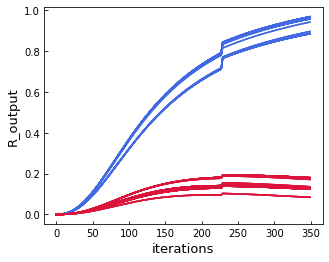

In [30]:
fig=plt.figure(figsize=(5,4))
ax=fig.add_subplot(111)

target=target_0
yseries=yseries0_7x7
for i in range(0,len(patterns)):
    if target[i]==target_H:
        ax.plot(np.array(yseries).T[i],color='royalblue')
        
    if target[i]==target_L:
        ax.plot(np.array(yseries).T[i],color='crimson')
    
ax.set_xlabel('iterations',fontsize=13)
ax.set_ylabel('R_output',fontsize=13)
ax.tick_params(direction='in')

#fig_path='/Users/ximing/Documents/technion_stuff/figures/'
#plt.savefig(fig_path+'Routput_iterations.png',dpi=300)

In [43]:
#output_0_5x5,_=examine_output(w0_5x5,patterns_5x5,phi_pos,phi_neg)
#output_1_5x5,_=examine_output(w1_5x5,patterns_5x5,phi_pos,phi_neg)
#output_2_5x5,_=examine_output(w2_5x5,patterns_5x5,phi_pos,phi_neg)

#output_0_7x7,_=examine_output(w0_7x7,patterns_7x7,phi_pos,phi_neg)
#output_1_7x7,_=examine_output(w1_7x7,patterns_7x7,phi_pos,phi_neg)
#output_2_7x7,_=examine_output(w2_7x7,patterns_7x7,phi_pos,phi_neg)

output_0_9x9,_=examine_output(w0_9x9,patterns_9x9,phi_pos,phi_neg)
output_1_9x9,_=examine_output(w1_9x9,patterns_9x9,phi_pos,phi_neg)
output_2_9x9,_=examine_output(w2_9x9,patterns_9x9,phi_pos,phi_neg)

In [46]:
w2_9x9_txt=", ".join("%.0f" % f for f in w2_9x9)
print(w2_9x9_txt)

-8, 40, 41, 40, 40, 1275, 1275, 1275, 40, 40, 1275, 1275, 1275, 41, 1275, 1275, 1275, 41, 41, 1275, 8960, 8960, 7726, 8960, 8960, 1275, 40, 40, 8960, 1275, 1275, 40, 1275, 1275, 8960, 40, 7726, 1275, 1275, 1275, 41, 1275, 1275, 1275, 7726, 8960, 40, 1275, 1275, 41, 1275, 1275, 40, 8961, 8960, 1275, 40, 1275, 41, 1276, 41, 1275, 8961, 8960, 1275, 1275, 40, 40, 41, 1275, 1275, 8960, 8960, 1275, 1275, 1275, -8, 40, 41, 40, 7726


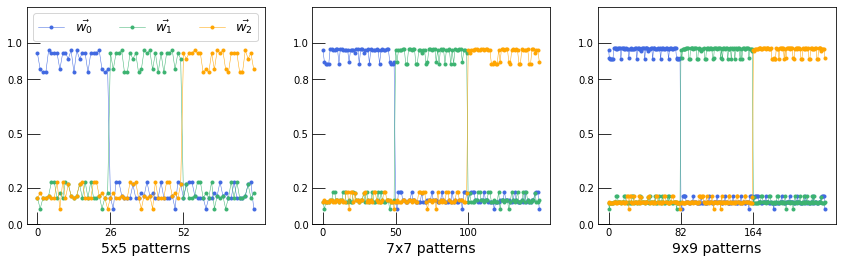

In [47]:
ymax=1.2

fig=plt.figure(figsize=(14.5,4))
#=======
ax=fig.add_subplot(131)

line0,=ax.plot(np.arange(0,len(output_0_5x5)),output_0_5x5,marker='.',lw=0.5,color='royalblue',label='$\\vec{w_0}$')
line1,=ax.plot(np.arange(0,len(output_1_5x5)),output_1_5x5,marker='.',lw=0.5,color='mediumseagreen',label='$\\vec{w_1}$')
line2,=ax.plot(np.arange(0,len(output_2_5x5)),output_2_5x5,marker='.',lw=0.5,color='orange',label='$\\vec{w_2}$')
ax.set_ylim([0,ymax])
ax.tick_params(direction='in',size=12.5)
ax.set_yticks([0,0.2,0.5,0.8,1.0])
ax.set_xlabel('5x5 patterns',fontsize=14)
ax.legend(loc='upper left',ncol=3,fontsize=13)
ax.set_xticks([0,26,52])
#=======
ax=fig.add_subplot(132)

ax.plot(np.arange(0,len(output_0_7x7)),output_0_7x7,marker='.',lw=0.5,color='royalblue')
ax.plot(np.arange(0,len(output_1_7x7)),output_1_7x7,marker='.',lw=0.5,color='mediumseagreen')
ax.plot(np.arange(0,len(output_2_7x7)),output_2_7x7,marker='.',lw=0.5,color='orange')
ax.set_ylim([0,ymax])
ax.tick_params(direction='in',size=12.5)
ax.set_yticks([0,0.2,0.5,0.8,1.0])
ax.set_xlabel('7x7 patterns',fontsize=14)
ax.set_xticks([0,50,100])



#=======
ax=fig.add_subplot(133)

ax.plot(np.arange(0,len(output_0_9x9)),output_0_9x9,marker='.',lw=0.5,color='royalblue')
ax.plot(np.arange(0,len(output_1_9x9)),output_1_9x9,marker='.',lw=0.5,color='mediumseagreen')
ax.plot(np.arange(0,len(output_2_9x9)),output_2_9x9,marker='.',lw=0.5,color='orange')
ax.set_ylim([0,ymax])
ax.tick_params(direction='in',size=12.5)
ax.set_yticks([0,0.2,0.5,0.8,1.0])
ax.set_xlabel('9x9 patterns',fontsize=14)
ax.set_xticks([0,82,164])


fig_path='/Users/ximing/Documents/technion_stuff/figures/'
plt.savefig(fig_path+'larger_scale_patterns.png',dpi=400)

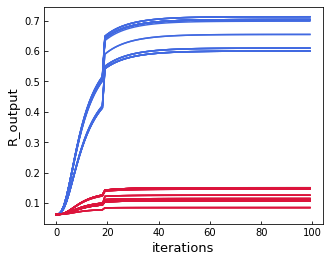

In [448]:
fig=plt.figure(figsize=(5,4))
ax=fig.add_subplot(111)

for i in range(0,len(y_n)):
    if target_0[i]==target_H:
        ax.plot(np.array(y_series0).T[i],color='royalblue')
        
    if target_0[i]==target_L:
        ax.plot(np.array(y_series0).T[i],color='crimson')
    
ax.set_xlabel('iterations',fontsize=13)
ax.set_ylabel('R_output',fontsize=13)
ax.tick_params(direction='in')

#fig_path='/Users/ximing/Documents/technion_stuff/figures/'
#plt.savefig(fig_path+'Routput_iterations.png',dpi=300)

In [140]:
# 06-01-2020
# basinhopping method

# update based on bishop PRAM, chapter 4
# sequential learning

AHL_unit_level=3e4
r=size
x=np.linspace(0.0,AHL_unit_level,2)#*AHL_unit_level
#K_neg,y0_neg,ym_neg,n_neg=37.87475102,0.29041731,0.76293279,2
#K_neg,y0_neg,ym_neg,n_neg=475.59048845,0.342,0.590,0.69197127
#transf_n=transf_rep(x,K=K_neg,y0=y0_neg,ym=ym_neg,n=n_neg)
#transf_p=transf_fcn(x)
transf_n=np.array([900,270])
transf_p=np.array([0.15,1.0])
phi_pos=np.array([transf_p]*size)
phi_neg=np.array([transf_n]*size)
    

def func(w0):
    y=np.zeros(len(patterns))

    for n in range(0,len(patterns)):
        pttn=np.array(patterns[n])
        phi_nw=(1.0+w0/np.sqrt(w0**2))/2*output_fcn(pttn,phi_pos)+\
            (1.0-w0/np.sqrt(w0**2))/2*output_fcn(pttn,phi_neg)/w0
        y[n]=activate(np.dot(w0,phi_nw)/r)
        
    product=(2*y-target_H)*(2*target-target_H)

    return np.var(product)*10+(target_H-np.mean(product))



In [ ]:
np.random.seed=3
w=np.random.random(size)
w=w0
minimizer_kwargs = {"method": "Nelder-Mead"}  #SLSQP  #Nelder-Mead #Powell gives negative entries
res=basinhopping(func,w,minimizer_kwargs=minimizer_kwargs,niter=30)
print(res.lowest_optimization_result.success)
for i in range(0,len(res.x)):print(res.x[i],',')

In [65]:
# notes: parameters in receiver activation functions Kd is unknown, here used Kd=10
# the value of Kd affects the absolute values of mutations 

w0_n=res.x
#w0_n=w0
y_n,w_ph=examine_output(w0_n,patterns)
product=(2*y_n-target_H)*(2*target-target_H)
print(y_n)
print(w_ph)
print(target_H-np.mean(product)+10*np.var(product))


[0.98 0.98 0.78 0.78 0.93 0.98 0.98 0.98 0.97 0.98 0.93 0.98 0.98 0.78
 0.93 0.93 0.78 0.09 0.09 0.19 0.18 0.1  0.09 0.09 0.09 0.09 0.09 0.08
 0.09 0.09 0.18 0.1  0.1  0.19]
[966.33 966.34 809.22 809.83 926.95 966.3  966.33 966.97 964.1  966.33
 926.95 967.07 966.3  809.75 926.95 926.95 808.88 220.58 220.57 377.68
 377.07 259.95 220.55 220.58 221.22 218.35 220.57 181.2  221.32 220.55
 377.16 259.95 259.95 378.02]
0.3677211997649403


[1.25 1.18 1.17 1.17 1.26 1.25 1.25 1.25 1.18 1.25 1.25 1.23 1.26 1.17
 1.26 1.23 1.25 1.25 1.17 1.25 1.25 1.25 1.26 1.18 1.17 1.18 0.24 0.15
 0.39 0.39 0.26 0.24 0.24 0.24 0.37 0.24 0.24 0.28 0.26 0.39 0.26 0.28
 0.24 0.24 0.39 0.24 0.24 0.24 0.26 0.15 0.39 0.37 0.24 0.37 0.39 0.39
 0.26 0.24 0.24 0.24 0.15 0.24 0.24 0.28 0.26 0.39 0.26 0.28 0.24 0.24
 0.39 0.24 0.24 0.24 0.26 0.37 0.39 0.15]


Text(0.5, 1.0, 'step two')

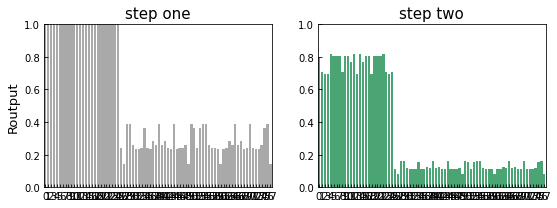

In [110]:
y_w0,_=examine_output(w0,patterns)
print(y_w0)
x=np.arange(0,len(y_w0))
fig=plt.figure(figsize=(9,3))
ax=fig.add_subplot(121)
sns.barplot(x,y_w0,color='darkgrey')
ax.set_ylim([0,1])
ax.tick_params(direction='in')
ax.tick_params(axis='x',labelbottom='off')
ax.set_ylabel('Routput',fontsize=13)
ax.set_title('step one', fontsize=15)

#----
ax=fig.add_subplot(122)
sns.barplot(x,y_n,color='mediumseagreen')
ax.set_ylim([0,1])
ax.tick_params(direction='in')
ax.tick_params(axis='x',labelbottom='off')
ax.set_title('step two', fontsize=15)

#fig_path='/Users/ximing/Documents/technion_stuff/figures/'
#plt.savefig(fig_path+'n_output_bargraph_n=4.0.png',dpi=300)